## PUI2016 HW9: Time series analysis with the MTA turnstile data

#### The goal of this analysis is to find outliers, trends and periodicity in the MTA turnstile data.

#### The dataset used contains weekly data for 600 Manhattan stations for each of the 23 different subway cards. This dataset was organized by Sina Kashuk (srk325(at)nyu.edu) at CUSP.

In [77]:
# Python 2 / 3 comp
from __future__ import print_function
from __future__ import division

# Standard imports to work with timeseries, plotting, etc.
import pylab as pl
import numpy as np
import pandas as pd
import os
import json
import requests
import urllib2
from IPython.display import Image

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
pl.rcParams.update(data)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
# Obtain the data for the Analysis (from the fbb55 HW9 Github Repo)
# https://github.com/fedhere/PUI2016_fb55/raw/master/HW9_fb55/MTA_Fare.npy

if not os.path.isfile(os.getenv("PUIDATA") + "/" "MTA_Fare.npy"):
    os.system("curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW9_fb55/MTA_Fare.npy")
    os.system("mv MTA_Fare.npy " + os.getenv("PUIDATA"))
    print ("file downloaded to PUIDATA directory, you can continue")
else:
    print ("file in place, you can continue")

file downloaded to PUIDATA directory, you can continue


In [79]:
# Load the python data cube

mtarides = np.load(os.getenv("PUIDATA") + "/" "MTA_Fare.npy")
print (mtarides.shape)

# Basic Data Cleanup (Convert to float and replace the -1 with NaN)

mtarides = mtarides.astype(numpy.float, copy = False)
mtarides[mtarides == -1] = np.nan

# Create an array with the redetype
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

# Create a date range for the weeks
rng = pd.date_range('5/21/2010', periods=194, freq='W')

(600, 23, 194)


In [78]:
# now we can use the nan functions that properly deal with the absence of data

print ("Using nanmean on mtarides: " + str (np.nanmean(mtarides)))
print ("Using regular mean on mtarides: " + str (np.mean(mtarides)))

Using nanmean on mtarides: 2849.41627865
Using regular mean on mtarides: nan


### Analysis 1: Event Detection

#### The first part of the analysis will attempt to identify the most prominent event. This event is defined as a very significant drop (>3-sigma) in all time series.

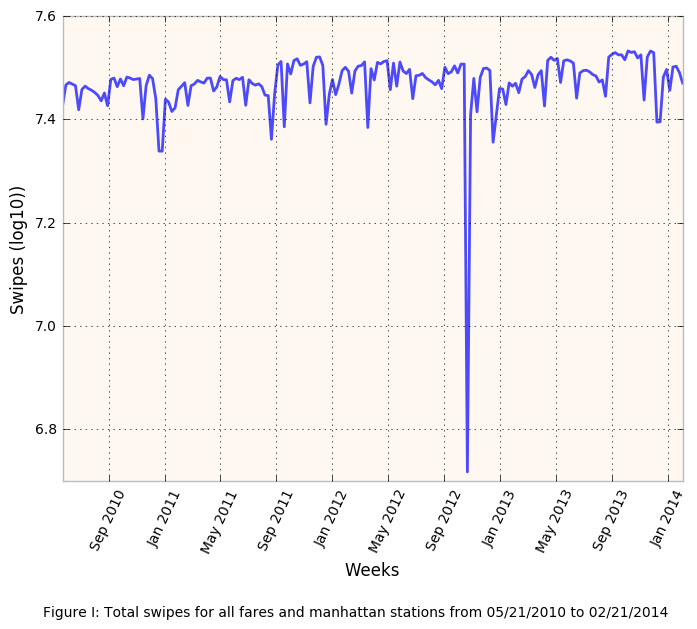

In [95]:
# Sum the timeseries for all stations and fares (we are looking fpr an event that we know is common to all 
# time series)

mtarides_allStations = np.nansum(mtarides, axis = 0)
# print (mtarides_allStations.shape)

mtarides_allStationsAndFares = np.nansum(mtarides_allStations, axis = 0)
# print (mtarides_allStationsAndFares.shape)

pl.figure(figsize=(8, 6))
pl.xlabel("Weeks")
pl.ylabel("Swipes (log10))") 

# Plot sum of all rides (using log10 on the y axis to improve visibility)
pl.plot(rng, np.log10(mtarides_allStationsAndFares),'b', alpha=0.7)
pl.xticks(rotation='65')
pl.legend(loc='upper left')

figtext(0.1,-.1,"Figure I: Total swipes for all fares and manhattan stations from 05/21/2010 to 02/21/2014")

In [122]:
# Identifying the event: We will take the mean and standard deviation 
# and find points that deviate from the mean by more than 3 standard deviations
# bellow code snippet from https://github.com/fedhere/UInotebooks/blob/master/timeseries/FDNYdeaths.ipynb

print ("mean swipes by week {:.2f}".format(np.nanmean(mtarides_allStationsAndFares)))
print ("stdev swipes by week {:.2f}".format(np.nanstd(mtarides_allStationsAndFares)))

thresholds = [np.nanmean(mtarides_allStationsAndFares) + 3 * np.nanstd(mtarides_allStationsAndFares), 
              np.nanmean(mtarides_allStationsAndFares) - 3 * np.nanstd(mtarides_allStationsAndFares)]

print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))
print ("earliest datapoint", min(rng))

mean swipes by week 29781349.87
stdev swipes by week 2983960.42
3-sigma thresholds 38733231.14 20829468.61
earliest datapoint 2010-05-23 00:00:00


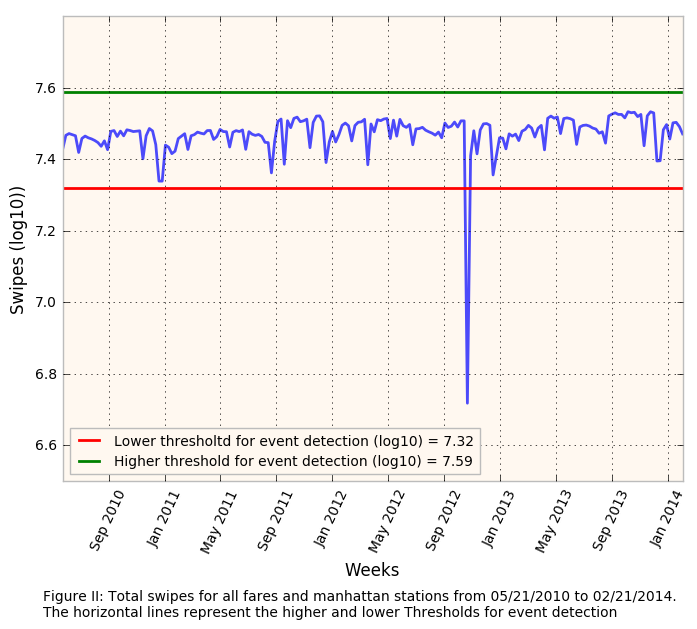

In [131]:
pl.figure(figsize=(8, 6))
pl.xlabel("Weeks")
pl.ylabel("Swipes (log10))") 
pl.ylim(6.5,7.8)

# Plot sum of all rides (using log10 on the y axis to improve visibility)
pl.plot(rng, np.log10(mtarides_allStationsAndFares),'b', alpha=0.7)
pl.xticks(rotation='65')

# Plot the lower Thereshold for the event detection
pl.plot((min(rng), max(rng)),(np.log10(thresholds[1]),np.log10(thresholds[1])), color='r',
       label='Lower thresholtd for event detection (log10) = %.2f' % np.log10(thresholds[1]))

# Plot the higher Thereshold for the event detection
pl.plot((min(rng), max(rng)),(np.log10(thresholds[0]),np.log10(thresholds[0])), color='g',
        label='Higher threshold for event detection (log10) = %.2f' % np.log10(thresholds[0]))

figtext(0.1,-.1,"Figure II: Total swipes for all fares and manhattan stations from 05/21/2010 to 02/21/2014. \n"
 "The horizontal lines represent the higher and lower Thresholds for event detection")
pl.legend(loc='lower left')

In [138]:
# Get the date for the event and try to explain what it might be related to
print (rng[np.where(mtarides_allStationsAndFares < 20829468.61)])

DatetimeIndex(['2012-10-21'], dtype='datetime64[ns]', freq=None)


#### A simple web search for MTA october 2012 gives a hint on the drop of swipes that we see on the week of 2012-10-21:
#### On Sunday, October 28, 2012 - 07:00 there was an MTA System-wide Shutdown in preparation for Hurcane Sandy.

#### http://www.mta.info/news/2012/10/28/mta-system-wide-shutdown

### Analysis 2: Trend Analysis

#### The second part of the analysis will attempt to identify trends on the ridership types. In particular, those ridership types that  have either steadily increased and decreased in popularity. We will try to quantify those changes by calculating the reation of ussage between the first 10 and last 10 weeks.

In [198]:
# Sum the timeseries for all stations and fares (we are looking fpr an event that we know is common to all 
# time series)

mtarides_allStations = np.nansum(mtarides, axis = 0)
# print (mtarides_allStations.shape)

mtarides_allStations.shape

len(mtarides_allStations)


for n in range(0,len(mtarides_allStations)):
    print ((np.min(mtarides_allStations[n]))>0)

True
True
True
True
True
True
True
False
False
False
False
True
False
True
True
True
True
False
True
True
True
False
False


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


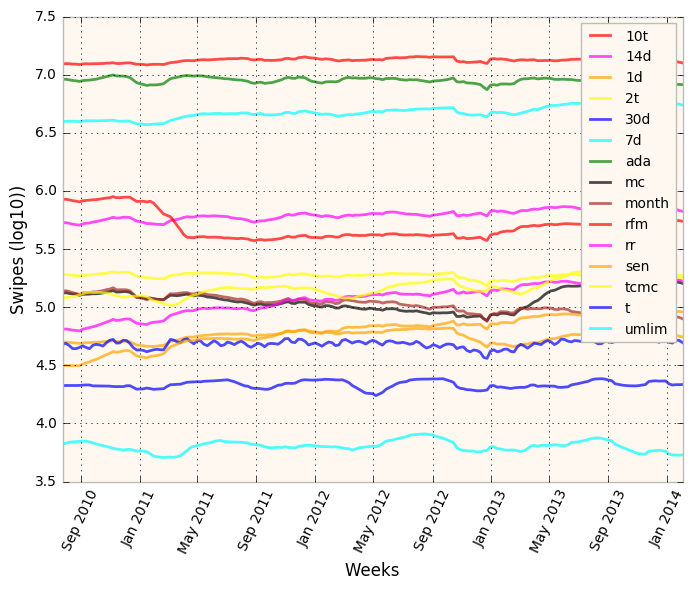

In [199]:
pl.figure(figsize=(8, 6))
pl.xlabel("Weeks")
pl.ylabel("Swipes (log10))") 
#pl.xlim('2010-05-09', '2014-09-01')

#print (min(np.log10(pd.stats.moments.rolling_mean(mtarides_allStations[0], 10))))

#print (np.nanmin(np.log10(pd.stats.moments.rolling_mean(mtarides_allStations[0], 10))))

color_seq = ['red','magenta','orange','yellow','blue','cyan','green','black','brown']

seqlen = len(color_seq)

def plot_rtype(rtype, color):
    pl.plot(rng, np.log10(pd.stats.moments.rolling_mean(mtarides_allStations[rtype], 10)), color=color, 
           alpha = .7, label = ridetype[rtype])
    
curr_col = 0

for n in range(0,len(mtarides_allStations)):
    #Check if the time series is continuous 
    if ((np.min(mtarides_allStations[n])) > 0):
    # Plot sum of all rides (using log10 on the y axis to improve visibility)
        #if ((np.nanmin(np.log10(pd.stats.moments.rolling_mean(mtarides_allStations[n], 10))) > 4) &
        #((np.nanmax(np.log10(pd.stats.moments.rolling_mean(mtarides_allStations[n], 10))) < 6))):
        #pl.plot(rng, np.log10(pd.stats.moments.rolling_mean(mtarides_allStations[n], 10)),
        #alpha=0.7, )
        plot_rtype(n, color_seq[curr_col])
        curr_col = (curr_col + 1)%seqlen

pl.xticks(rotation='65')
pl.legend()

